In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import datetime
import pandas as pd
from scipy.stats import norm

# Configuration

### Inputs

In [2]:
process_out_dir = '../../01_process/out/'

train_data_fpath = process_out_dir + 'train_data.npz'
valid_data_fpath = process_out_dir + 'valid_data.npz'
# not doing any test set stuff until the very, very end

mapping_reference = "../../01_process/in/MN_ice/raw_data_from_DNR/lake_ice_id_spreadsheet.xlsx"

### Values

In [3]:
epochs = 10000 # takes 9:21 to 

# plotting parameters
loss_curve_zoom_ymax = 0.15
loss_curve_zoom_ymin = 0.055

### Outputs

In [4]:
train_out_dir = '../out/'

data_scalars_fpath =  train_out_dir + 'min_max_scalars.pt'
model_weights_fpath = train_out_dir + 'basic_lstm_weights.pth'
train_predictions_fpath = train_out_dir + 'basic_lstm_train_preds.npy'
valid_predictions_fpath = train_out_dir + 'basic_lstm_valid_preds.npy'

# Import

In [5]:
train_data = np.load(train_data_fpath, allow_pickle = True)
valid_data = np.load(valid_data_fpath, allow_pickle = True)

In [6]:
train_data.files

['x', 'y', 'dates', 'DOW', 'features']

In [7]:
train_x = train_data['x']
train_y = train_data['y']
train_dates = train_data['dates']
train_DOW = train_data['DOW']
train_variables = train_data['features']

In [8]:
valid_x = valid_data['x']
valid_y = valid_data['y']
valid_dates = valid_data['dates']
valid_DOW = valid_data['DOW']
valid_variables = valid_data['features']

### Quick view of all the target sequences

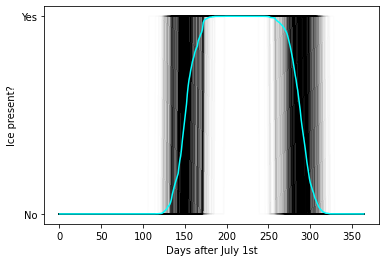

In [9]:
plt.plot(np.moveaxis(train_y, 0, 1), color = 'black', alpha = 0.01, label = 'obs')
plt.plot(np.mean(train_y, 0), label = 'avg obs', color = 'cyan')
plt.yticks([0, 1], ['No', 'Yes'])
plt.ylabel('Ice present?')
plt.xlabel('Days after July 1st');

# Prepare data for `torch`

In [10]:
train_y = torch.from_numpy(train_y).float().unsqueeze(2) # adding a feature dimension to Ys
train_x = torch.from_numpy(train_x).float()

valid_y = torch.from_numpy(valid_y).float().unsqueeze(2)
valid_x = torch.from_numpy(valid_x).float()

# min-max scale the training data

In [11]:
min_max_scalars = torch.zeros(train_x.shape[2], 2)

for i in range(train_x.shape[2]):
    min_max_scalars[i, 0] = train_x[:, :, i].min()
    min_max_scalars[i, 1] = train_x[:, :, i].max()

In [12]:
for i in range(train_x.shape[2]):
    # scale train set with train min/max
    train_x[:, :, i] = ((train_x[:, :, i] - min_max_scalars[i, 0]) /
                        (min_max_scalars[i, 1] - min_max_scalars[i, 0]))
    # scale valid set with train min/max
    valid_x[:, :, i] = ((valid_x[:, :, i] - min_max_scalars[i, 0]) /
                        (min_max_scalars[i, 1] - min_max_scalars[i, 0]))

# Define a simple model

In [13]:
# recycled model code
class LSTMDA(nn.Module):
    def __init__(self, input_dim, hidden_dim, recur_dropout = 0, dropout = 0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()
        
        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)
        
        self.dense = nn.Linear(hidden_dim, 1)
        self.dense_activation = nn.Sigmoid()
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
        
    def forward(self, x, init_states = None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
        
        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * self.recur_dropout(g_t)
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(1))
        hidden_seq = torch.cat(hidden_seq, dim= 1)
        out = self.dense_activation(self.dense(hidden_seq))
        
        return out, (h_t, c_t)

In [14]:
# initialize the model with a seed
torch.manual_seed(0)

# very small model
# maps 13 variables to hidden dim of 1 via LSTM layer
# transforms that LSTM out with a dense layer (scale and bias)
# then sigmoid activation for probability
model = LSTMDA(13, 1)

# Training

### Train loop

In [15]:
loss_fn = torch.nn.BCELoss()
loss_ls = []
valid_loss_ls = []

optimizer = torch.optim.Adam(model.parameters())
for i in range(epochs):
    train_y_hat, (h, c) = model(train_x)
    loss = loss_fn(train_y_hat, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_ls.append(loss.item())
    
    if i % int(epochs / 10) == 0:
        print(i, loss.item())
        
    with torch.no_grad():
        valid_y_hat, (h, c) = model(valid_x)
        valid_loss = loss_fn(valid_y_hat, valid_y)
        valid_loss_ls.append(valid_loss.item())

0 0.6721848845481873
1000 0.2518007755279541
2000 0.15378081798553467
3000 0.11448317766189575
4000 0.09057896584272385
5000 0.07716691493988037
6000 0.06924161314964294
7000 0.06483340263366699
8000 0.062301136553287506
9000 0.06059271842241287


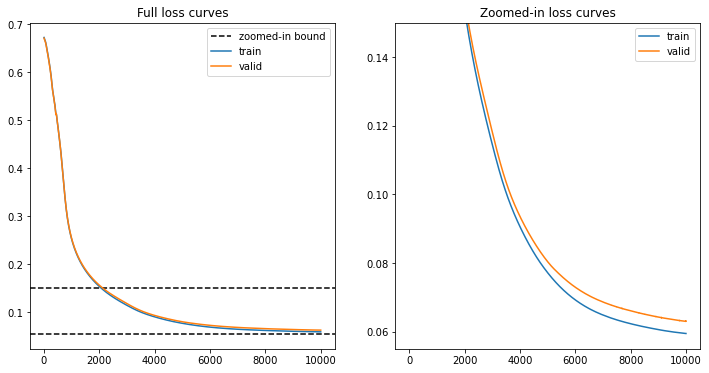

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax[0].axhline(loss_curve_zoom_ymax, color = 'black', linestyle = '--',
              label = 'zoomed-in bound')
ax[0].axhline(loss_curve_zoom_ymin, color = 'black', linestyle = '--')
ax[0].plot(loss_ls, label = 'train')
ax[0].plot(valid_loss_ls, label = 'valid')
ax[0].set_title('Full loss curves')
ax[0].legend()

ax[1].plot(loss_ls, label = 'train')
ax[1].plot(valid_loss_ls, label = 'valid')
ax[1].set_ylim(loss_curve_zoom_ymin, loss_curve_zoom_ymax)
ax[1].set_title('Zoomed-in loss curves')
ax[1].legend();

# Save predictions for evaluation

To save on file size, I'm not going to rebundle the other objects, they can be combined later with a simple concatenate

In [17]:
train_y_hat, (h, c) = model(train_x)
valid_y_hat, (h, c) = model(valid_x)

In [18]:
train_y_hat = train_y_hat.detach().numpy()
valid_y_hat = valid_y_hat.detach().numpy()

In [19]:
np.save(train_predictions_fpath, train_y_hat)
np.save(valid_predictions_fpath, valid_y_hat)

# Save model weights and min-max scalars

In [20]:
torch.save(min_max_scalars, data_scalars_fpath)
torch.save(model.state_dict(), model_weights_fpath)